## MNIST Handwritten Digits Classification Experiment

### Install Python SDKs

In [17]:
import sys

In [18]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.24

  Using cached sagemaker_experiments-0.1.24-py3-none-any.whl (36 kB)
  Attempting uninstall: sagemaker-experiments
    Found existing installation: sagemaker-experiments 0.1.31
    Uninstalling sagemaker-experiments-0.1.31:
      Successfully uninstalled sagemaker-experiments-0.1.31


### Install PyTroch

In [19]:
# pytorch version needs to be the same in both the notebook instance and the training job container
# https://github.com/pytorch/pytorch/issues/25214
!{sys.executable} -m pip install torch==1.1.0
!{sys.executable} -m pip install torchvision==0.3.0
!{sys.executable} -m pip install pillow==6.2.2
!{sys.executable} -m pip install --upgrade sagemaker

Killed
  Using cached torchvision-0.3.0-cp36-cp36m-manylinux1_x86_64.whl (2.6 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0a0+78ed10c
    Uninstalling torchvision-0.7.0a0+78ed10c:
      Successfully uninstalled torchvision-0.7.0a0+78ed10c
  Using cached Pillow-6.2.2-cp36-cp36m-manylinux1_x86_64.whl (2.1 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0
    Uninstalling Pillow-8.2.0:
      Successfully uninstalled Pillow-8.2.0
     |████████████████████████████████| 416 kB 30.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.47.2.post0-py2.py3-none-any.whl size=584473 sha256=7910a41ab6dfb6ec12740f32e991f0fc1b9eec086aae7f1294897e9808ae3249
  Stored in directory: /root/.cache/pip/wheels/18/83/42/02f5b1eadb8fd2500507e36c22f56652882d6b6012069e47ad
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.44.0
    Uninstalling sagemaker-2.44.0:
  

### Setup

In [20]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats("retina")

In [21]:
sess = boto3.Session()
sm = sess.client("sagemaker")
role = get_execution_role()

### Create a S3 bucket to hold data

In [22]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client("sts").get_caller_identity()["Account"]
bucket = "sagemaker-experiments-{}-{}".format(sess.region_name, account_id)
prefix = "mnist"

try:
    if sess.region_name == "us-east-1":
        sess.client("s3").create_bucket(Bucket=bucket)
    else:
        sess.client("s3").create_bucket(
            Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": sess.region_name}
        )
except Exception as e:
    print(e)

### Dataset
We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [23]:
# TODO: can be removed after upgrade to torchvision==0.9.1
# see github.com/pytorch/vision/issues/1938 and github.com/pytorch/vision/issues/3549
datasets.MNIST.urls = [
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz",
    "https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz",
]

# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST(
    "mnist",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=False,
)

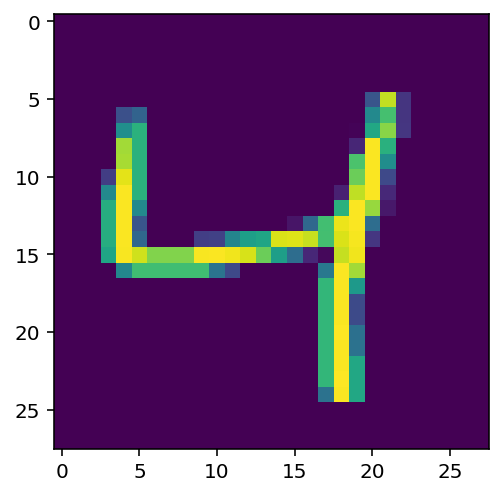

In [24]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [25]:
inputs = sagemaker.Session().upload_data(path="mnist", bucket=bucket, key_prefix=prefix)
print("input spec: {}".format(inputs))

input spec: s3://sagemaker-experiments-us-east-1-435647692548/mnist


Now lets track the parameters from the data pre-processing step.

In [26]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters(
        {
            "normalization_mean": 0.1307,
            "normalization_std": 0.3081,
        }
    )
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [27]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}",
    description="Classification of mnist hand-written digits",
    sagemaker_boto_client=sm,
)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fdc51491c18>,experiment_name='mnist-hand-written-digits-classification-1625181476',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:435647692548:experiment/mnist-hand-written-digits-classification-1625181476',response_metadata={'RequestId': '820457a5-6461-47cf-99cc-57df18e51132', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '820457a5-6461-47cf-99cc-57df18e51132', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Thu, 01 Jul 2021 23:17:55 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment
### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [28]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [29]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [30]:
preprocessing_trial_component = tracker.trial_component

In [ ]:
for i, num_hidden_channel in enumerate([2, 5]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name

    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)

    # all input configurations, parameters, and metrics specified in estimator
    # definition are automatically tracked
    estimator = PyTorch(
        #py_version="py3",
        entry_point="./mnist.py",
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        #framework_version="1.6.0",
        instance_count=1,
        instance_type="ml.p2.xlarge",
        image_uri = "",
        hyperparameters={
            "epochs": 2,
            "backend": "gloo",
            "hidden_channels": num_hidden_channel,
            "dropout": 0.2,
            "kernel_size": 5,
            "optimizer": "sgd",
        },
        metric_definitions=[
            {"Name": "train:loss", "Regex": "Train Loss: (.*?);"},
            {"Name": "test:loss", "Regex": "Test Average loss: (.*?),"},
            {"Name": "test:accuracy", "Regex": "Test Accuracy: (.*?)%;"},
        ],
        enable_sagemaker_metrics=True,
    )

    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))

    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={"training": inputs},
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )

    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1625181477


2021-07-01 23:17:58 Starting - Starting the training job...
2021-07-01 23:17:59 Starting - Launching requested ML instancesProfilerReport-1625181477: InProgress
...
2021-07-01 23:18:55 Starting - Preparing the instances for training............
2021-07-01 23:20:56 Downloading - Downloading input data
2021-07-01 23:20:56 Training - Downloading the training image..............................
2021-07-01 23:25:58 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-01 23:25:59,541 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-07-01 23:25:59,566 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-01 23:26:02,593 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-01 23:26:03,090 sagemaker-training-toolkit INFO     Invoking user scr

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: cnn-training-job-1625182737


2021-07-01 23:38:58 Starting - Starting the training job...
2021-07-01 23:39:21 Starting - Launching requested ML instancesProfilerReport-1625182738: InProgress
......
2021-07-01 23:40:21 Starting - Preparing the instances for training.........
2021-07-01 23:41:59 Downloading - Downloading input data
2021-07-01 23:41:59 Training - Downloading the training image.....................

### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [ ]:
search_expression = {
    "Filters": [
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [ ]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=["test:accuracy"],
    parameter_names=["hidden_channels", "epochs", "dropout", "optimizer"],
)

In [18]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,...,test:accuracy - Last,test:accuracy - Count,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,cnn-training-job-1621777148-aws-training-job,Training,arn:aws:sagemaker:us-east-1:435647692548:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,...,97.0,2,None,s3://sagemaker-experiments-us-east-1-435647692...,None,s3://sagemaker-us-east-1-435647692548/,None,s3://sagemaker-us-east-1-435647692548/cnn-trai...,[cnn-training-job-2-hidden-channels-1621777148],[mnist-hand-written-digits-classification-1621...
1,cnn-training-job-1621778004-aws-training-job,Training,arn:aws:sagemaker:us-east-1:435647692548:train...,0.2,2.0,20.0,"""sgd""",96.0,97.0,96.5,...,97.0,2,None,s3://sagemaker-experiments-us-east-1-435647692...,None,s3://sagemaker-us-east-1-435647692548/,None,s3://sagemaker-us-east-1-435647692548/cnn-trai...,[cnn-training-job-20-hidden-channels-1621778004],[mnist-hand-written-digits-classification-1621...
2,cnn-training-job-1621777719-aws-training-job,Training,arn:aws:sagemaker:us-east-1:435647692548:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,...,97.0,2,None,s3://sagemaker-experiments-us-east-1-435647692...,None,s3://sagemaker-us-east-1-435647692548/,None,s3://sagemaker-us-east-1-435647692548/cnn-trai...,[cnn-training-job-10-hidden-channels-1621777719],[mnist-hand-written-digits-classification-1621...
3,cnn-training-job-1621778289-aws-training-job,Training,arn:aws:sagemaker:us-east-1:435647692548:train...,0.2,2.0,32.0,"""sgd""",95.0,97.0,96.0,...,97.0,2,None,s3://sagemaker-experiments-us-east-1-435647692...,None,s3://sagemaker-us-east-1-435647692548/,None,s3://sagemaker-us-east-1-435647692548/cnn-trai...,[cnn-training-job-32-hidden-channels-1621778289],[mnist-hand-written-digits-classification-1621...
4,cnn-training-job-1621777434-aws-training-job,Training,arn:aws:sagemaker:us-east-1:435647692548:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,...,96.0,2,None,s3://sagemaker-experiments-us-east-1-435647692...,None,s3://sagemaker-us-east-1-435647692548/,None,s3://sagemaker-us-east-1-435647692548/cnn-trai...,[cnn-training-job-5-hidden-channels-1621777434],[mnist-hand-written-digits-classification-1621...


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [19]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    search_expression={
        "Filters": [
            {
                "Name": "Parents.TrialName",
                "Operator": "Equals",
                "Value": hidden_channel_trial_name_map[2],
            }
        ]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [20]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,mnist-dataset - MediaType,mnist-dataset - Value,Trials,Experiments,SourceArn,SageMaker.ImageUri,...,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count,training - MediaType,training - Value,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value
0,TrialComponent-2021-05-23-133852-xitn,Preprocessing,0.1307,0.3081,s3/uri,s3://sagemaker-experiments-us-east-1-435647692...,[cnn-training-job-5-hidden-channels-1621777434...,[mnist-hand-written-digits-classification-1621...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1621777148-aws-training-job,Training,NaN,NaN,NaN,NaN,[cnn-training-job-2-hidden-channels-1621777148],[mnist-hand-written-digits-classification-1621...,arn:aws:sagemaker:us-east-1:435647692548:train...,520713654638.dkr.ecr.us-east-1.amazonaws.com/s...,...,0.456703,0.352488,0.157259,18.0,NaN,s3://sagemaker-experiments-us-east-1-435647692...,NaN,s3://sagemaker-us-east-1-435647692548/,NaN,s3://sagemaker-us-east-1-435647692548/cnn-trai...


## Deploy endpoint for the best training-job / trial component

Now we'll take the best (as sorted) and create an endpoint for it.

In [21]:
# Pulling best based on sort in the analytics/dataframe so first is best....
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]["TrialComponentName"]
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts["SageMaker.ModelArtifact"].value
env = {
    "hidden_channels": str(int(best_trial_component.parameters["hidden_channels"])),
    "dropout": str(best_trial_component.parameters["dropout"]),
    "kernel_size": str(int(best_trial_component.parameters["kernel_size"])),
}
model = PyTorchModel(
    model_data,
    role,
    "./mnist.py",
    py_version="py3",
    env=env,
    sagemaker_session=sagemaker.Session(sagemaker_client=sm),
    framework_version="1.1.0",
    name=best_trial_component.trial_component_name,
)

predictor = model.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1)

INFO:sagemaker:Creating model with name: cnn-training-job-1621777148-aws-training-job
INFO:sagemaker:Creating endpoint with name cnn-training-job-1621777148-aws-trainin-2021-05-23-14-02-56-920


-------------!

## Cleanup

Once we're doing don't forget to clean up the endpoint to prevent unnecessary billing.

> Trial components can exist independent of trials and experiments. You might want keep them if you plan on further exploration. If so, comment out tc.delete()

In [22]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: cnn-training-job-1621777148-aws-trainin-2021-05-23-14-02-56-920
INFO:sagemaker:Deleting endpoint with name: cnn-training-job-1621777148-aws-trainin-2021-05-23-14-02-56-920


In [23]:
mnist_experiment.delete_all(action="--force")

## Contact
Submit any questions or issues to https://github.com/aws/sagemaker-experiments/issues or mention @aws/sagemakerexperimentsadmin 